In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openeye import oechem, oedepict

from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

from fragmenter import torsions, chemi
import numpy as np

from autograd import grad
from autograd import numpy as np

In [3]:
# Create openeye molecules and add conformers with torsion angle at 15 degree intervals
smiles = ['c1cc(ccc1c2ccncc2)O', 'c1cc(ccc1c2cc[nH+]cc2)O', 'c1cc(ccc1c2ccncc2)[O-]', 'c1cc(ccc1c2cc[nH+]cc2)[O-]']
names = ['neutral', 'cation', 'anion', 'zwitterion']
# Create openeye molecules
oemols = [chemi.smiles_to_oemol(sm, add_atom_map=True) for sm in smiles]
for i, mol in enumerate(oemols):
    mol.SetTitle(names[i])
    
conf_mols = []
# Find torsion to constrain
for mol in oemols:
    for bond in mol.GetBonds():
        if bond.IsRotor():
            rot_bond = bond
            break
    bond_map = (rot_bond.GetBgn().GetMapIdx(), rot_bond.GetEnd().GetMapIdx())
    dih = torsions.find_torsion_around_bond(molecule=mol, bond=bond_map)
    conformers = chemi.generate_grid_conformers(mol, dihedrals=[dih], intervals=[15])
    conf_mols.append(conformers)

In [4]:
off_molecules = [Molecule.from_openeye(mol) for mol in conf_mols]
topologies = [Topology.from_molecules(mol) for mol in off_molecules]
forcefield = ForceField('openff-1.0.0.offxml')



In [5]:
for i, top in enumerate(topologies):
    print('\n')
    print(off_molecules[i])
    molecule_force_list = forcefield.label_molecules(top)
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        print(f'Forces for molecule {mol_idx}')
        for force_tag, force_dict in mol_forces.items():
            if force_tag != 'ProperTorsions':
                continue
            print(f"\n{force_tag}:")
            for (atom_indices, parameter) in force_dict.items():
                if atom_indices == tuple(dih):
                    atomstr=''
                    for idx in atom_indices:
                        atomstr += '%3s' % idx
                    print("atoms: %s  parameter_id: %s  smirks %s" % (atomstr, parameter.id, parameter.smirks) )




Molecule with name 'neutral' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])O[H])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'cation' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])O[H])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'anion' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])[O-])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'zwitterion' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])[O-])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


In [6]:
# Create OMM systems
from simtk import openmm, unit

#integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

systems = [forcefield.create_openmm_system(top) for top in topologies]
simulations = [openmm.app.Simulation(topologies[i], systems[i], mm.VerletIntegrator(1*unit.femtosecond)) for i in range(4)]

In [7]:
all_energies = []
all_angles = []
for i, mol in enumerate(off_molecules):
    energies = []
    angles = []
    for j in range(24):
        simulation = simulations[i]
        angles.append(torsions.measure_dihedral_angle(coords=mol.conformers[j]._value, dihedral=dih))
        simulation.context.setPositions(mol.conformers[j])
        state = simulation.context.getState(getEnergy=True)
        energy = state.getPotentialEnergy()
        energies.append(energy._value)
    energies = np.asanyarray(energies) - min(energies)
    all_energies.append(energies)
    all_angles.append(angles)

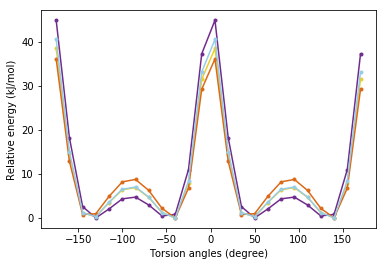

In [8]:
colors = chemi._KELLYS_COLORS
for i in range(4):
    plt.plot(all_angles[i][12:] + all_angles[i][:12], np.concatenate((all_energies[i][12:], all_energies[i][:12])), color=colors[i])
    plt.plot(all_angles[i][12:] + all_angles[i][:12], np.concatenate((all_energies[i][12:], all_energies[i][:12])), '.', color=colors[i])
plt.xlabel('Torsion angles (degree)')
plt.ylabel('Relative energy (kJ/mol)')
plt.savefig('biphenyl_mm_torsion_scan.pdf', bbox_inches='tight')

In [75]:
# From Josh - constrained minimzation 

def compute_dihedral(xyz, indices):
    """Copied from mdtraj, except without calls to a non-python distance library,
    and assuming we dont have to deal with periodic stuff"""
    
    a,b,c,d = indices
    b1 = xyz[b] - xyz[a]
    b2 = xyz[c] - xyz[b]
    b3 = xyz[d] - xyz[c]
    
    c1 = np.cross(b2, b3) # bc x cd
    c2 = np.cross(b1, b2) # ab x bc

    p1 = np.sum(b1 * c1)
    p1 *= np.sum(b2 * b2) ** 0.5
    p2 = np.sum(c1 * c2)

    return np.arctan2(p1, p2)

def unflatten(flat_xyz):
    N = int(len(flat_xyz) / 3)
    return np.reshape(flat_xyz, (N, 3))

def set_positions(xyz):
    simulation.context.setPositions(xyz)
    
E_unit = simulation.context.getState(getEnergy=True).getPotentialEnergy().unit
F_unit = simulation.context.getState(getForces=True).getForces(asNumpy=True).unit
    
def get_energy(xyz):
    set_positions(xyz)
    return simulation.context.getState(getEnergy=True).getPotentialEnergy() / E_unit

def get_forces(xyz):
    set_positions(xyz)
    return simulation.context.getState(getForces=True).getForces(asNumpy=True) / F_unit

def fxn_to_minimize(flat_xyz):
    return get_energy(unflatten(flat_xyz))

def jacobian_of_fxn(flat_xyz):
    return - get_forces(unflatten(flat_xyz))



In [10]:
# Get a system
integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

simulation = simulations[0]
xyz = off_molecules[0].conformers[0].in_units_of(unit.nanometer)
simulation.context.setPositions(xyz)
flat_xyz = (xyz / unit.nanometer).flatten()

In [11]:
fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)

(387.15155029296875, array([[  512.05950928,  -267.55859375,  -463.5881958 ],
        [  627.47064209,  -336.04086304,  -258.81332397],
        [ -274.18374634,   151.41256714,   -53.90885544],
        [  -55.53871918,    24.17018318,   216.37582397],
        [ -774.40844727,   501.77185059,  -255.8913269 ],
        [ -272.22390747,    56.24277878,   910.92425537],
        [-1039.71350098,   538.46484375,   678.17028809],
        [-1057.34436035,   570.05255127,   631.75488281],
        [ -352.51309204,   189.51731873,   217.09686279],
        [  666.59411621,  -359.22131348,  -419.15820312],
        [  408.62518311,  -219.37353516,  -256.40472412],
        [ 1291.38452148,  -682.84436035,  -810.90246582],
        [  120.70637512,   -62.97424316,   -73.27740479],
        [ 1100.31445312,  -430.5269165 ,  -592.0189209 ],
        [  937.62695312,  -654.86444092,  -674.35327148],
        [   36.8917923 ,   -16.82372665,   -79.7412262 ],
        [  -21.63752747,    11.07032776,    26.85806

In [12]:
from functools import partial

def dihedral_constraint(flat_xyz, target_dihedral=0.0):
    """equality constraint: want the output of this function to be 0"""
    xyz = unflatten(flat_xyz)
    return compute_dihedral(xyz, torsion_indices) - target_dihedral

In [13]:
from scipy.optimize import minimize

def form_eq_constraint(target_dihedral):
    """adapted from scipy documentation
    https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp
    """
    
    fun = partial(dihedral_constraint, target_dihedral=target_dihedral)

    eq_cons = {'type': 'eq',
               'fun' : fun,
               'jac' : grad(fun)}
    return eq_cons

In [30]:
target_dihedral = 0
torsion_indices = dih
eq_cons = form_eq_constraint(target_dihedral)
eq_cons['jac'](flat_xyz)

array([ -3.9966948 ,  -7.24618613,  -0.23349414,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         4.29775471,   7.0672432 ,   0.8681694 ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         7.99896673,  14.15260393,   0.76520708,  -8.30002664,
       -13.973661  ,  -1.39988234,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [31]:
eq_cons

{'type': 'eq',
 'fun': functools.partial(<function dihedral_constraint at 0xa275fb730>, target_dihedral=0),
 'jac': <function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>}

In [33]:
from scipy.optimize import show_options
show_options('minimize', method='SLSQP')

Minimize a scalar function of one or more variables using Sequential
Least SQuares Programming (SLSQP).

Options
-------
ftol : float
    Precision goal for the value of f in the stopping criterion.
eps : float
    Step size used for numerical approximation of the Jacobian.
disp : bool
    Set to True to print convergence messages. If False,
    `verbosity` is ignored and set to 0.
maxiter : int
    Maximum number of iterations.


In [52]:
results_2 = [] 
for j in range(24):
    simulation = simulations[0]
    xyz = off_molecules[0].conformers[j].in_units_of(unit.nanometer)
    angle = torsions.measure_dihedral_angle(coords=xyz._value, dihedral=dih)
    simulation.context.setPositions(xyz)
    flat_xyz = (xyz / unit.nanometer).flatten()
    fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)
    target_dihedral = (angle) *np.pi/180
    print(angle)
    print(target_dihedral)
    torsion_indices = dih
    eq_cons = form_eq_constraint(target_dihedral)
    # jiggle xyz
    minimum = get_energy(xyz)
    print('initial_energy: {}'.format(minimum))
    for i in range(5):
        flat_xyz = flat_xyz + np.random.normal(0, 0.01, flat_xyz.shape)
        new_result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
           constraints=[form_eq_constraint(target_dihedral)],
                        options={'ftol': 1e-10, 'disp': True, 'maxiter': 8000})
        minimum = min(minimum, new_result.fun)
        if new_result.fun == minimum:
            result = new_result
    print('final_energy: {}'.format(result.fun))
    results_2.append(result)

5.00000039606522
0.08726646951235861
initial_energy: 387.15155029296875
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 299.1799621582031
            Iterations: 305
            Function evaluations: 1610
            Gradient evaluations: 305
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 287.4985046386719
            Iterations: 554
            Function evaluations: 3076
            Gradient evaluations: 554
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 301.872802734375
            Iterations: 1033
            Function evaluations: 6956
            Gradient evaluations: 1033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.2943115234375
            Iterations: 828
            Function evaluations: 6505
            Gradient evaluations: 828
Optimization terminated successfully.    (Exit mode 0)
            Curr

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 309.08599853515625
            Iterations: 356
            Function evaluations: 2294
            Gradient evaluations: 356
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 308.9484558105469
            Iterations: 1488
            Function evaluations: 12015
            Gradient evaluations: 1488
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 313.93194580078125
            Iterations: 3017
            Function evaluations: 28891
            Gradient evaluations: 3017
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 308.91558837890625
            Iterations: 2632
            Function evaluations: 23686
            Gradient evaluations: 2632
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 308.92626953125
            Iterations: 9

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.54925537109375
            Iterations: 1116
            Function evaluations: 10209
            Gradient evaluations: 1116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.4969482421875
            Iterations: 589
            Function evaluations: 3353
            Gradient evaluations: 589
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.6050720214844
            Iterations: 513
            Function evaluations: 4168
            Gradient evaluations: 513
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.52490234375
            Iterations: 2031
            Function evaluations: 15618
            Gradient evaluations: 2031
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.737548828125
            Iterations: 194
   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 296.6474609375
            Iterations: 247
            Function evaluations: 1271
            Gradient evaluations: 247
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 302.3280334472656
            Iterations: 1368
            Function evaluations: 12735
            Gradient evaluations: 1368
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 302.3832702636719
            Iterations: 1171
            Function evaluations: 9715
            Gradient evaluations: 1171
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 296.4868469238281
            Iterations: 432
            Function evaluations: 3468
            Gradient evaluations: 432
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 296.49530029296875
            Iterations: 1143
   

In [57]:
simulation = simulations[1]

In [61]:
all_energies[0]

[     fun: 287.4985046386719
      jac: array([-7.09561157e+00, -3.18770809e+01, -7.07954407e+00,  6.08657837e-01,
        -1.53363609e+00,  5.95369434e+00,  1.38012481e+00,  3.90867567e+00,
        -2.30654621e+00, -8.25966167e+00,  2.09083319e+00, -6.67649555e+00,
         1.70307236e+01,  2.80009937e+01, -4.05016708e+00,  6.83330631e+00,
         5.33386612e+00, -4.00164413e+00, -2.96322060e+00,  1.66595268e+00,
         4.36588287e-01, -2.00952530e-01, -5.83236694e-01,  3.74863434e+00,
         1.95536804e+01,  6.30516701e+01,  4.30796432e+00, -2.35652294e+01,
        -6.08064575e+01, -9.21799660e+00,  2.99947882e+00,  6.55755281e-01,
         8.28597546e+00,  6.76399231e-01, -1.68944454e+00,  1.12170792e+00,
        -6.68051453e+02, -2.18200562e+03, -4.79653473e+02, -1.47852143e-02,
         1.96175128e-02,  2.89883674e-03, -1.30738825e-01, -2.32321071e-03,
         1.74027309e-01,  4.02145386e-02, -1.09519958e+00, -6.73522949e-01,
         2.01014709e+00, -2.04706955e+00, -1.8619

In [62]:
all_energies = [results_2]
results = []
for j in range(24):
    simulation = simulations[1]
    xyz = off_molecules[1].conformers[j].in_units_of(unit.nanometer)
    angle = torsions.measure_dihedral_angle(coords=xyz._value, dihedral=dih)
    simulation.context.setPositions(xyz)
    flat_xyz = (xyz / unit.nanometer).flatten()
    fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)
    target_dihedral = (angle) *np.pi/180
    print(angle)
    print(target_dihedral)
    torsion_indices = dih
    eq_cons = form_eq_constraint(target_dihedral)
    # jiggle xyz
    minimum = get_energy(xyz)
    print('initial_energy: {}'.format(minimum))
    for i in range(5):
        flat_xyz = flat_xyz + np.random.normal(0, 0.01, flat_xyz.shape)
        new_result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
           constraints=[form_eq_constraint(target_dihedral)],
                        options={'ftol': 1e-10, 'disp': True, 'maxiter': 8000})
        minimum = min(minimum, new_result.fun)
        if new_result.fun == minimum:
            result = new_result
    print('final_energy: {}'.format(result.fun))
    results.append(result)
all_energies.append(results)

4.9999983375209505
0.08726643358398331
initial_energy: 669.99072265625
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 362.95452880859375
            Iterations: 1146
            Function evaluations: 10879
            Gradient evaluations: 1146
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 377.88726806640625
            Iterations: 1385
            Function evaluations: 12081
            Gradient evaluations: 1385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 357.34710693359375
            Iterations: 4715
            Function evaluations: 40465
            Gradient evaluations: 4715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 356.29339599609375
            Iterations: 3314
            Function evaluations: 28116
            Gradient evaluations: 3314
Optimization terminated successfully.    (Exit mode 0)
  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 381.3533630371094
            Iterations: 595
            Function evaluations: 5069
            Gradient evaluations: 595
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 381.5201416015625
            Iterations: 765
            Function evaluations: 6407
            Gradient evaluations: 765
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 382.14227294921875
            Iterations: 1119
            Function evaluations: 10554
            Gradient evaluations: 1119
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 380.5943603515625
            Iterations: 207
            Function evaluations: 949
            Gradient evaluations: 207
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 381.466064453125
            Iterations: 2325
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 365.1268005371094
            Iterations: 2207
            Function evaluations: 18588
            Gradient evaluations: 2207
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 372.90966796875
            Iterations: 612
            Function evaluations: 4234
            Gradient evaluations: 612
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 363.72442626953125
            Iterations: 199
            Function evaluations: 624
            Gradient evaluations: 199
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 368.42755126953125
            Iterations: 693
            Function evaluations: 5089
            Gradient evaluations: 693
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 369.2158203125
            Iterations: 619
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 369.15557861328125
            Iterations: 183
            Function evaluations: 846
            Gradient evaluations: 183
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 367.62713623046875
            Iterations: 2723
            Function evaluations: 26106
            Gradient evaluations: 2723
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 368.8644104003906
            Iterations: 448
            Function evaluations: 3329
            Gradient evaluations: 448
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 371.7209777832031
            Iterations: 883
            Function evaluations: 7259
            Gradient evaluations: 883
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 413.11480712890625
            Iterations: 270
  

In [68]:
simulation = simulations[2]

In [70]:
results = []
for j in range(24):
    simulation = simulations[2]
    xyz = off_molecules[2].conformers[j].in_units_of(unit.nanometer)
    angle = torsions.measure_dihedral_angle(coords=xyz._value, dihedral=dih)
    simulation.context.setPositions(xyz)
    flat_xyz = (xyz / unit.nanometer).flatten()
    fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)
    target_dihedral = (angle) *np.pi/180
    print(angle)
    print(target_dihedral)
    torsion_indices = dih
    eq_cons = form_eq_constraint(target_dihedral)
    # jiggle xyz
    minimum = get_energy(xyz)
    print('initial_energy: {}'.format(minimum))
    for i in range(5):
        flat_xyz = flat_xyz + np.random.normal(0, 0.01, flat_xyz.shape)
        new_result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
           constraints=[form_eq_constraint(target_dihedral)],
                        options={'ftol': 1e-10, 'disp': True, 'maxiter': 8000})
        minimum = min(minimum, new_result.fun)
        if new_result.fun == minimum:
            result = new_result
    print('final_energy: {}'.format(result.fun))
    results.append(result)
all_energies.append(results)

4.9999973338889605
0.08726641606730061
initial_energy: 313.58575439453125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 206.91943359375
            Iterations: 482
            Function evaluations: 4422
            Gradient evaluations: 482
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 206.91940307617188
            Iterations: 102
            Function evaluations: 460
            Gradient evaluations: 102
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 206.9194793701172
            Iterations: 99
            Function evaluations: 452
            Gradient evaluations: 99
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 206.91944885253906
            Iterations: 886
            Function evaluations: 8515
            Gradient evaluations: 886
Optimization terminated successfully.    (Exit mode 0)
            Current

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 226.25389099121094
            Iterations: 136
            Function evaluations: 942
            Gradient evaluations: 136
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 226.25387573242188
            Iterations: 85
            Function evaluations: 408
            Gradient evaluations: 85
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 226.25392150878906
            Iterations: 137
            Function evaluations: 956
            Gradient evaluations: 137
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 226.25393676757812
            Iterations: 874
            Function evaluations: 8512
            Gradient evaluations: 874
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 226.2539520263672
            Iterations: 138
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 212.98959350585938
            Iterations: 214
            Function evaluations: 1654
            Gradient evaluations: 214
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 212.98960876464844
            Iterations: 1811
            Function evaluations: 18728
            Gradient evaluations: 1811
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 212.98959350585938
            Iterations: 349
            Function evaluations: 2457
            Gradient evaluations: 349
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 212.98956298828125
            Iterations: 1098
            Function evaluations: 9298
            Gradient evaluations: 1098
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 826.158203125
            Iterations: 705
  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 214.72360229492188
            Iterations: 512
            Function evaluations: 4700
            Gradient evaluations: 512
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 214.72360229492188
            Iterations: 791
            Function evaluations: 7671
            Gradient evaluations: 791
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 214.7236785888672
            Iterations: 118
            Function evaluations: 475
            Gradient evaluations: 118
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 214.72369384765625
            Iterations: 2124
            Function evaluations: 21990
            Gradient evaluations: 2124
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 214.72372436523438
            Iterations: 563
 

In [74]:
simulation = simulations[3]

In [76]:
results = []
for j in range(24):
    simulation = simulations[3]
    xyz = off_molecules[3].conformers[j].in_units_of(unit.nanometer)
    angle = torsions.measure_dihedral_angle(coords=xyz._value, dihedral=dih)
    simulation.context.setPositions(xyz)
    flat_xyz = (xyz / unit.nanometer).flatten()
    fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)
    target_dihedral = (angle) *np.pi/180
    print(angle)
    print(target_dihedral)
    torsion_indices = dih
    eq_cons = form_eq_constraint(target_dihedral)
    # jiggle xyz
    minimum = get_energy(xyz)
    print('initial_energy: {}'.format(minimum))
    for i in range(5):
        flat_xyz = flat_xyz + np.random.normal(0, 0.01, flat_xyz.shape)
        new_result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
           constraints=[form_eq_constraint(target_dihedral)],
                        options={'ftol': 1e-10, 'disp': True, 'maxiter': 8000})
        minimum = min(minimum, new_result.fun)
        if new_result.fun == minimum:
            result = new_result
    print('final_energy: {}'.format(result.fun))
    results.append(result)
all_energies.append(results)

5.00000219957739
0.08726650098958408
initial_energy: 525.806396484375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 370.5536804199219
            Iterations: 566
            Function evaluations: 4456
            Gradient evaluations: 566
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 353.6408996582031
            Iterations: 545
            Function evaluations: 3498
            Gradient evaluations: 545
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 354.260498046875
            Iterations: 753
            Function evaluations: 5838
            Gradient evaluations: 753
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 354.1597900390625
            Iterations: 1321
            Function evaluations: 12104
            Gradient evaluations: 1321
Optimization terminated successfully.    (Exit mode 0)
            Curre

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 391.41766357421875
            Iterations: 833
            Function evaluations: 7158
            Gradient evaluations: 833
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 373.2293701171875
            Iterations: 1402
            Function evaluations: 9984
            Gradient evaluations: 1402
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 373.1471252441406
            Iterations: 1229
            Function evaluations: 10713
            Gradient evaluations: 1229
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 373.97637939453125
            Iterations: 2442
            Function evaluations: 22512
            Gradient evaluations: 2442
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 391.4173583984375
            Iterations: 2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 360.7171630859375
            Iterations: 518
            Function evaluations: 3220
            Gradient evaluations: 518
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 360.07623291015625
            Iterations: 1673
            Function evaluations: 14110
            Gradient evaluations: 1673
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 360.04681396484375
            Iterations: 1666
            Function evaluations: 13491
            Gradient evaluations: 1666
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 365.2398376464844
            Iterations: 1007
            Function evaluations: 6459
            Gradient evaluations: 1007
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 360.67169189453125
            Iterations: 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 361.5239562988281
            Iterations: 1129
            Function evaluations: 8688
            Gradient evaluations: 1129
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 362.33673095703125
            Iterations: 3912
            Function evaluations: 38295
            Gradient evaluations: 3912
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 361.71417236328125
            Iterations: 1549
            Function evaluations: 12759
            Gradient evaluations: 1549
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 361.8609619140625
            Iterations: 3067
            Function evaluations: 29381
            Gradient evaluations: 3067
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 361.5523376464844
            Iterations

In [91]:
energies_1 = [i.fun for i in all_energies[0]]
energies_1 = energies_1[12:] + energies_1[:12]
energies_2 = [i.fun for i in all_energies[1]]
energies_2 = energies_2[12:] + energies_2[:12]
energies_3 = [i.fun for i in all_energies[2]]
energies_3 = energies_3[12:] + energies_3[:12]
energies_4 = [i.fun for i in all_energies[3]]
energies_4 = energies_4[12:] + energies_4[:12]

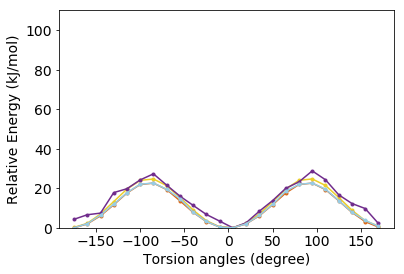

In [97]:
plt.plot(angles[12:]+angles[:12], np.asarray(energies_1)-min(energies_1), '.', color=colors[0])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_1)-min(energies_1), color=colors[0])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_2)-min(energies_2), '.', color=colors[1])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_2)-min(energies_2), color=colors[1])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_3)-min(energies_3), '.', color=colors[2])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_3)-min(energies_3), color=colors[2])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_4)-min(energies_4), '.', color=colors[3])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_4)-min(energies_4), color=colors[3])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Torsion angles (degree)', fontsize=14)
plt.ylabel('Relative Energy (kJ/mol)', fontsize=14)
plt.ylim(0, 110)
plt.savefig('biphenyl_mm_min_torsion_scan.pdf', bbox_inches='tight')

In [ ]:
all_results = []
for i, mol in enumerate(off_molecules):
    print(mol.name)
    angles = []
    results = []
    
    for j in range(24):
        simulation = simulations[i]
        xyz = mol.conformers[j].in_units_of(unit.nanometer)
        angle = torsions.measure_dihedral_angle(coords=xyz._value, dihedral=dih)
        simulation.context.setPositions(xyz)
        fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)
        flat_xyz = (xyz / unit.nanometer).flatten()
        target_dihedral = (angle-5) *np.pi/180
        print(angle)
        print(target_dihedral)
        torsion_indices = dih
        eq_cons = form_eq_constraint(target_dihedral)
        result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
               constraints=[form_eq_constraint(target_dihedral)],
                            options={'ftol': 1e-9, 'disp': True, 'maxiter': 2000})
        results.append(result)
    all_results.append(results)
    

neutral
5.00000039606522
6.9126421369603485e-09
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.37860107421875
            Iterations: 179
            Function evaluations: 953
            Gradient evaluations: 179
20.000004143757096
0.2617994601213542
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 295.4039001464844
            Iterations: 117
            Function evaluations: 487
            Gradient evaluations: 117
34.99999648294436
0.523598714214098
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 292.6991882324219
            Iterations: 325
            Function evaluations: 2299
            Gradient evaluations: 325
49.99999642240576
0.7853981009566494
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 298.5175476074219
            Iterations: 1607
            Function evaluations: 15760
            Gradient e

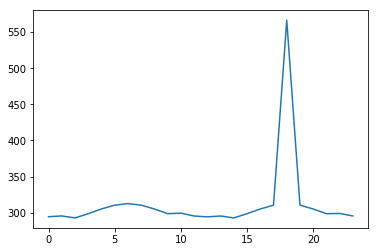

In [33]:
plt.plot(final_energies)